In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Datasets/Train'
valid_path = 'Datasets/Test'

In [4]:
# Import the Vgg 16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94773248/94765736 [==============================] - 994s 10us/step


In [5]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [6]:
# don't train existing weights
for layer in resnet.layers:
    layer.trainable = False

In [7]:
# useful for getting number of output classes
folders = glob('Datasets/train/*')

In [8]:
folders

['Datasets/train\\audi',
 'Datasets/train\\lamborghini',
 'Datasets/train\\mercedes']

In [9]:
x = Flatten()(resnet.output)

In [10]:
len(folders)

3

In [11]:
prediction = Dense(len(folders), activation='softmax')(x)
# create a model object
model = Model(inputs=resnet.input, outputs=prediction)
# view the structure of the model
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [12]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [14]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

#No data augumentation for the test dataset
test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
# Need to provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory('Datasets/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical') #for more than 2 classes

test_set = test_datagen.flow_from_directory('Datasets/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 64 images belonging to 3 classes.
Found 58 images belonging to 3 classes.


In [16]:
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
2/2 [==============================] - 10s 5s/step - loss: 8.3141 - accuracy: 0.2969 - val_loss: 9.2883 - val_accuracy: 0.3276
Epoch 2/50
2/2 [==============================] - 8s 4s/step - loss: 6.3651 - accuracy: 0.3125 - val_loss: 3.8174 - val_accuracy: 0.1552
Epoch 3/50
2/2 [==============================] - 8s 4s/step - loss: 6.6623 - accuracy: 0.2969 - val_loss: 6.4574 - val_accuracy: 0.5172
Epoch 4/50
2/2 [==============================] - 8s 4s/step - loss: 6.0237 - accuracy: 0.3281 - val_loss: 1.6501 - val_accuracy: 0.2069
Epoch 5/50
2/2 [==============================] - 8s 4s/step - loss: 1.9728 - accuracy: 0.4688 - val_loss: 6.7096 - val_accuracy: 0.3276
Epoch 6/50
2/2 [==============================] - 7s 4s/step - loss: 4.1884 - accuracy: 0.4375 - val_loss: 7.1832 - val_accuracy: 0.1724
Epoch 7/50
2/2 [==============================] - 8s 4s/step - loss: 3.9926 - accuracy: 0.4688 - val_

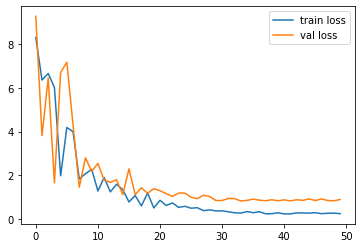

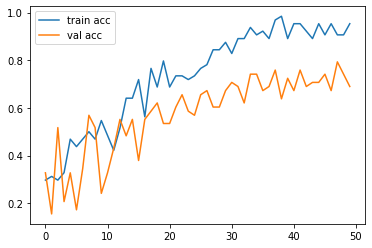

<Figure size 432x288 with 0 Axes>

In [17]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [18]:
from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')


In [19]:
y_pred = model.predict(test_set)
y_pred # Each list contains 3 probs indicating class

array([[1.72693381e-05, 1.53850226e-04, 9.99828815e-01],
       [3.11666757e-01, 1.83928981e-02, 6.69940293e-01],
       [3.31647903e-01, 2.79694408e-01, 3.88657689e-01],
       [3.04121571e-03, 3.39742117e-02, 9.62984622e-01],
       [8.37203413e-02, 6.77719116e-01, 2.38560557e-01],
       [1.11339358e-03, 7.37502456e-01, 2.61384189e-01],
       [7.73659468e-01, 1.10023782e-01, 1.16316706e-01],
       [4.50796150e-02, 7.66447335e-02, 8.78275633e-01],
       [8.01404472e-03, 9.42641914e-01, 4.93440442e-02],
       [6.32698539e-06, 1.17245934e-03, 9.98821199e-01],
       [1.53087938e-04, 9.90251899e-01, 9.59496666e-03],
       [8.00729729e-03, 9.11463499e-01, 8.05291608e-02],
       [1.25427581e-02, 3.99323553e-01, 5.88133633e-01],
       [8.40755776e-02, 4.98527229e-01, 4.17397201e-01],
       [3.51818055e-02, 1.72739439e-02, 9.47544217e-01],
       [3.56244110e-03, 3.69747728e-01, 6.26689851e-01],
       [1.86684467e-02, 3.11575949e-01, 6.69755638e-01],
       [1.16661843e-02, 2.58603

In [20]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)


In [21]:
y_pred

array([2, 2, 2, 2, 1, 1, 0, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 2, 1, 0, 1, 1, 2, 2, 0, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2,
       2, 1, 2, 2, 1, 2, 2, 1, 1, 1, 0, 2, 1, 1], dtype=int64)

In [22]:
#Test

In [23]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


In [24]:
model=load_model('model_resnet50.h5')

In [25]:
img=image.load_img('Datasets/Test/lamborghini/11.jpg',target_size=(224,224))

In [26]:
x=image.img_to_array(img)
x


array([[[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [194., 188., 174.],
        [215., 209., 197.],
        [241., 235., 223.]],

       [[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [247., 245., 233.],
        [245., 242., 233.],
        [244., 241., 232.]],

       [[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [245., 248., 241.],
        [244., 250., 248.],
        [244., 250., 248.]],

       ...,

       [[190., 206., 229.],
        [190., 206., 229.],
        [190., 206., 229.],
        ...,
        [172., 179., 187.],
        [171., 180., 187.],
        [171., 180., 187.]],

       [[187., 205., 227.],
        [187., 205., 227.],
        [187., 205., 227.],
        ...,
        [172., 179., 187.],
        [171., 180., 187.],
        [171., 180., 187.]],

       [[185., 206., 227.],
        [185., 206., 227.],
        [187., 2

In [27]:
x.shape

(224, 224, 3)

In [28]:
x=x/255

In [29]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [30]:
model.predict(img_data)

array([[0.01873257, 0.06764386, 0.9136235 ]], dtype=float32)

In [31]:
a=np.argmax(model.predict(img_data), axis=1)

In [32]:
a

array([2], dtype=int64)